In [2]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [3]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


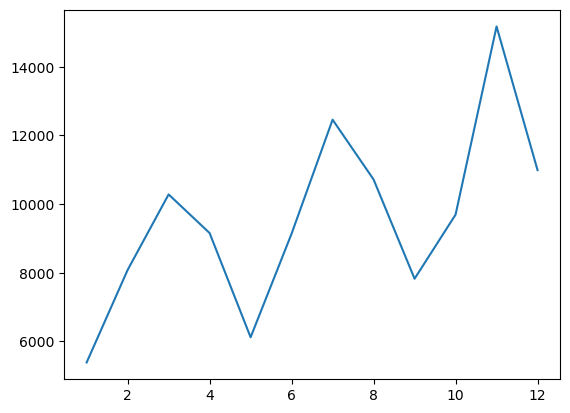

In [4]:
plt.plot(df['Period'], df["Sales"])

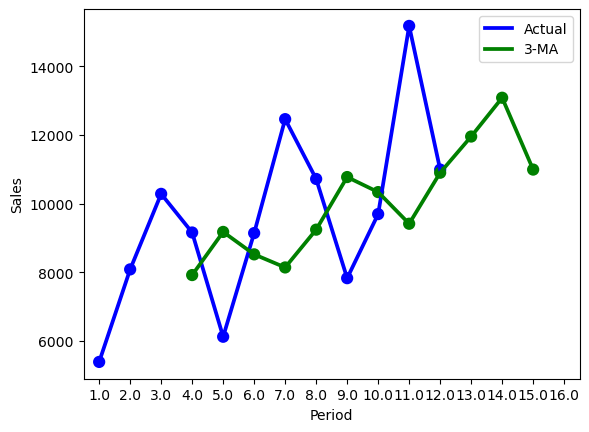

In [5]:
# Using moving average
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period','Sales'])
    for i in range(0, to_period):
        if i < k:
            prediction = float("nan")
        else:
            history = df["Sales"][i-k:i]
            prediction = history.mean()
        moving_average_df.loc[i] = [i+1, prediction]
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

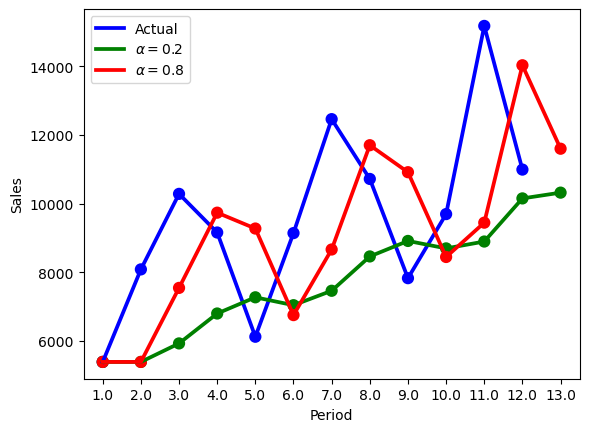

In [6]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1, df["Sales"][0]]
    for i in range(0, len(df)):
        prediction = alpha * df["Sales"][i] + (1 - alpha) * es_df["Sales"][i] 
        es_df.loc[i + 1] = [i + 2, prediction]
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

C:\Users\James\AppData\Local\Temp\ipykernel_12860\3470548057.py:19: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
C:\Users\James\AppData\Local\Temp\ipykernel_12860\3470548057.py:48: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


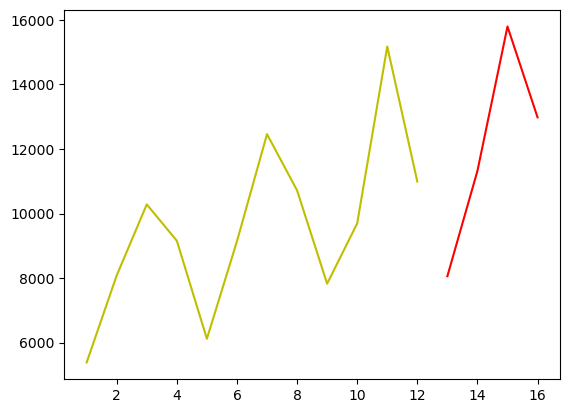

In [7]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    #create new dataframe which adds "season" classification
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)

    
    #average sales from each season
    avg_df = season_df.apply(np.mean)


    #for each period calculates the error from the avg from its season
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df["I"] / avg_df["I"]
    seasonal_index_df['II'] = season_df["II"] / avg_df["II"]
    seasonal_index_df['III'] = season_df["III"] / avg_df["III"]
    
    #average of each error
    seasonal_index_df['Avg'] = seasonal_index_df.apply(np.mean, axis=1)
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df["Avg"]*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

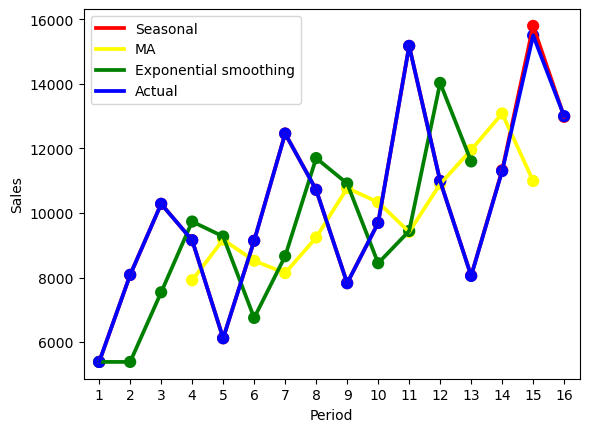

In [8]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [9]:
MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(df, 0.2)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(df, 0.8)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.absolute(eval_df["Sales"][12:16] - pd.concat([df, season_df], ignore_index=True)["Sales"][12:16]).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))


MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2267.8234691993603
MAD of Exponential smoothing with alpha=0.8: 3548.037820375039
MAD of Seasonality Method: 85.88221407247443


In [10]:
MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = (eval_df["Sales"][12:16] - exponential_smoothing(df, 0.2)["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = (eval_df["Sales"][12:16] - exponential_smoothing(df, 0.8)["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = (eval_df["Sales"][12:16] - pd.concat([df, season_df], ignore_index=True)["Sales"][12:16]) ** 2
MSE = MSE.mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 11544241.36111111
MSE of Exponential smoothing with alpha=0.2: 5143023.287451422
MSE of Exponential smoothing with alpha=0.8: 12588572.374811657
MSE of Seasonality Method: 22206.08964632366


In [11]:
from sklearn import preprocessing

In [12]:
df = pd.read_csv("opsd_germany_daily.csv", index_col=0)
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [13]:
df.describe()

,Consumption,Wind,Solar,Wind+Solar
count,4383.000000,2920.000000,2188.000000,2187.000000
mean,1338.675836,164.814173,89.258695,272.663481
std,165.775710,143.692732,58.550099,146.319884
min,842.395000,5.757000,1.968000,21.478000
25%,1217.859000,62.353250,35.179250,172.185500
50%,1367.123000,119.098000,86.407000,240.991000
75%,1457.761000,217.900250,135.071500,338.988000
max,1709.568000,826.278000,241.580000,851.556000


In [14]:
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

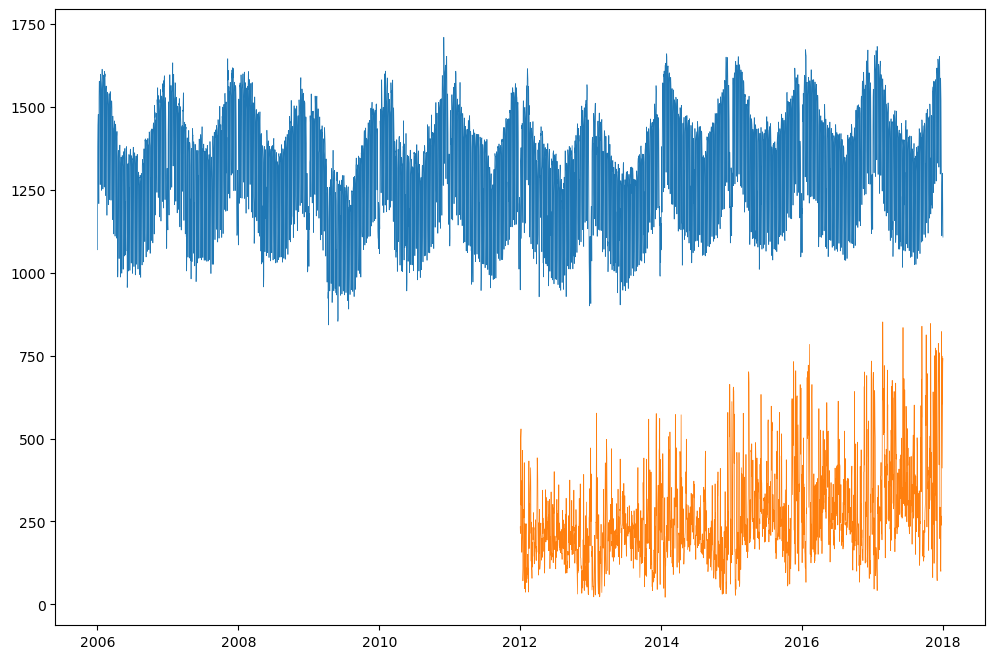

In [15]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'], linewidth=0.5)
plt.plot(df['Wind+Solar'], linewidth=0.5)
plt.show()

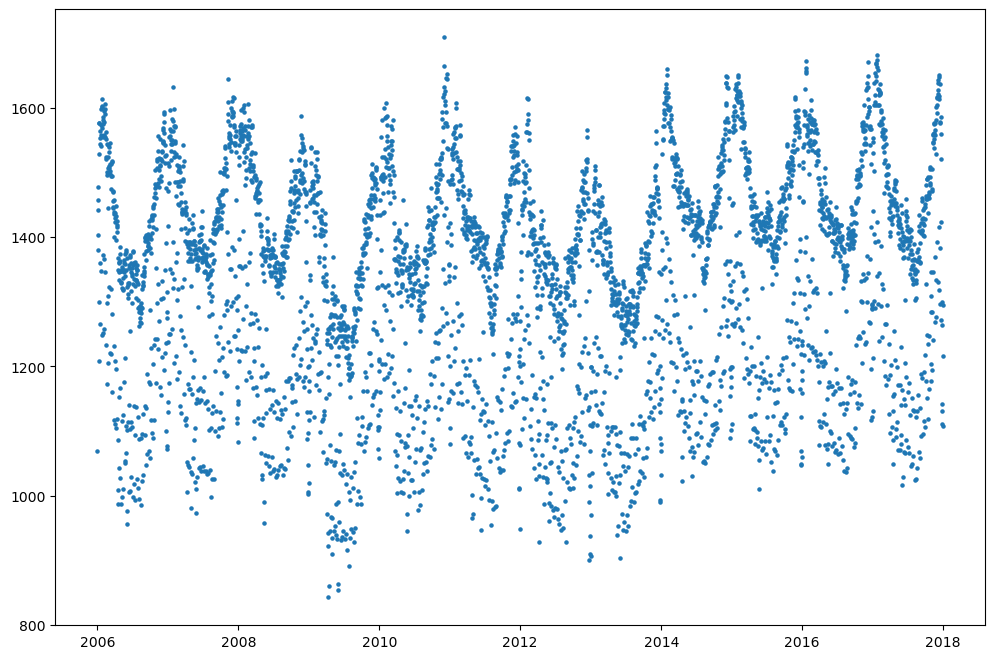

In [16]:
plt.figure(figsize=(12,8))
plt.scatter(df.index, df['Consumption'], s=5)
plt.plot(linestyle="None", marker=".")
plt.show()

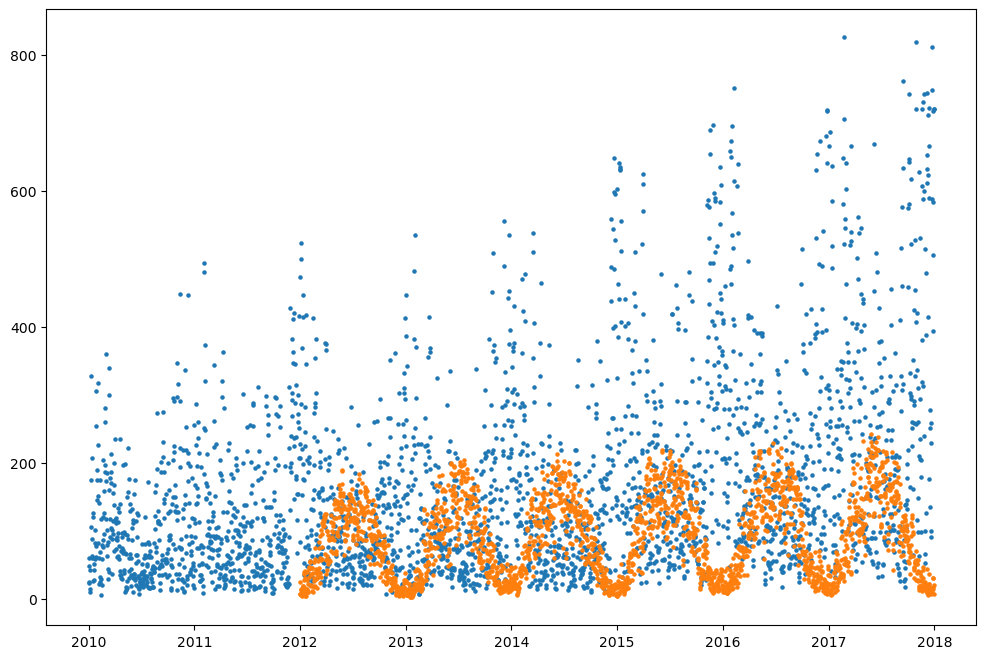

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(df.index, df['Wind'], s=5)
plt.plot(linestyle="None", marker=".")
plt.scatter(df.index, df['Solar'], s=5)

plt.show()

What can we notice ?

- the consumption is larger than the production
- we have no overall production data before 2012
- the production and the consumption are both seasonal, i.e. they vary within a year given some pattern
- there is a trend in production (the higher part), and outliers downwards

How do consumption and production compare ?

- We notice that wind bsaed production increases over time, and is rather high in winter (for example more storms).
- On the other hand, the solar production is higher in summer (seems logic)
- The consumption is higher in winter

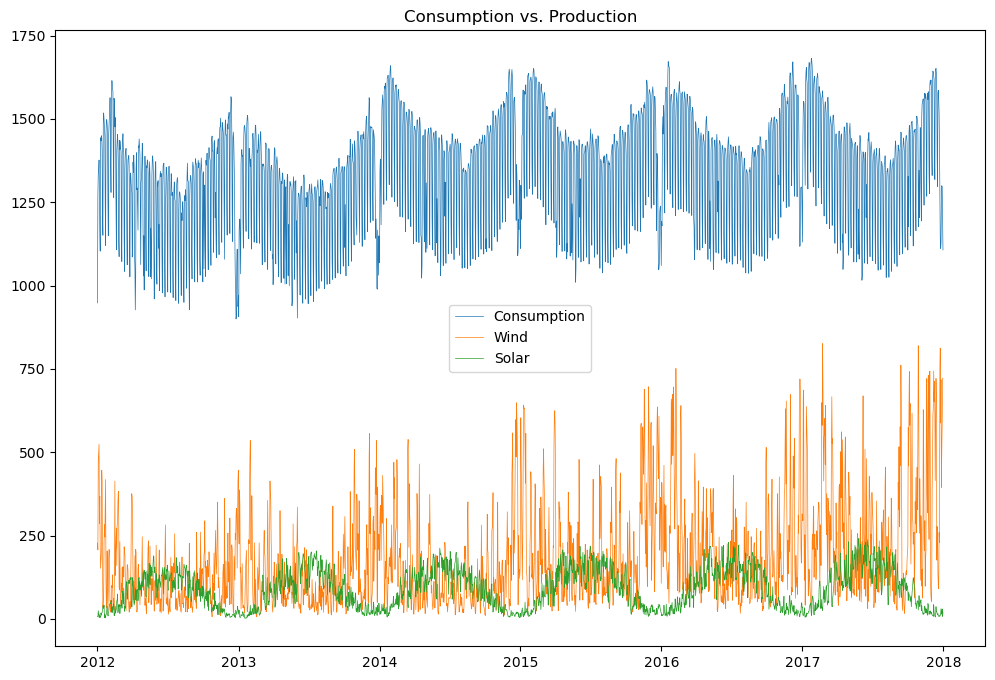

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].loc["2012-01-01":], label='Consumption', linewidth=0.5)
plt.plot(df['Wind'].loc["2012-01-01":], label='Wind', linewidth=0.5)
plt.plot(df['Solar'].loc["2012-01-01":], label='Solar',linewidth=0.5)
plt.title("Consumption vs. Production")
plt.legend()
plt.show()

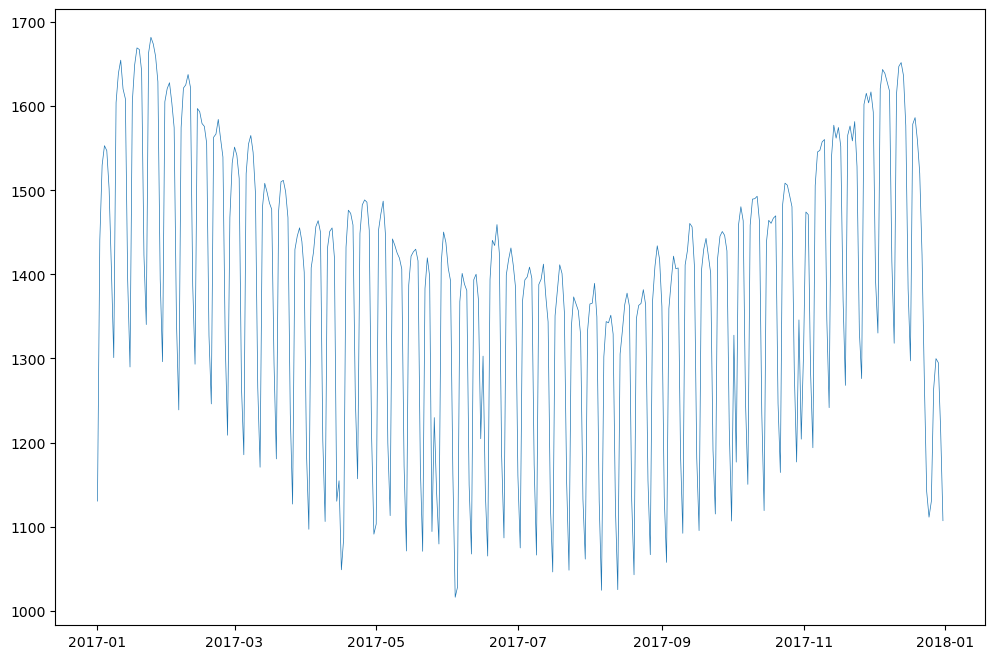

In [19]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].loc["2017-01-01":"2017-12-31"], label='Consumption', linewidth=0.5)
plt.show()

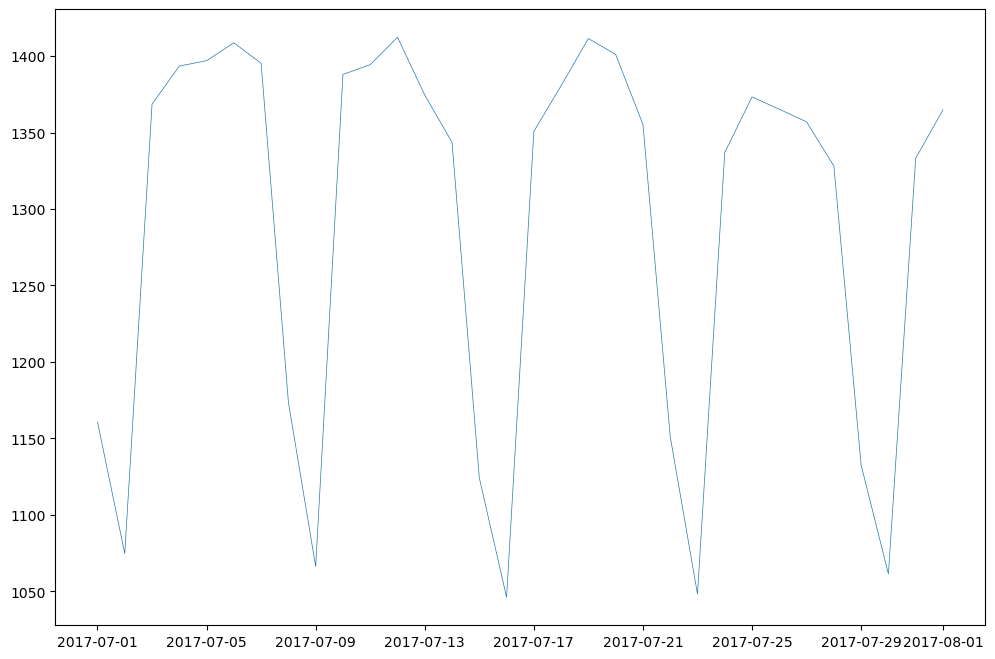

In [20]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].loc["2017-07-01":"2017-08-01"], label='Consumption', linewidth=0.5)
plt.show()

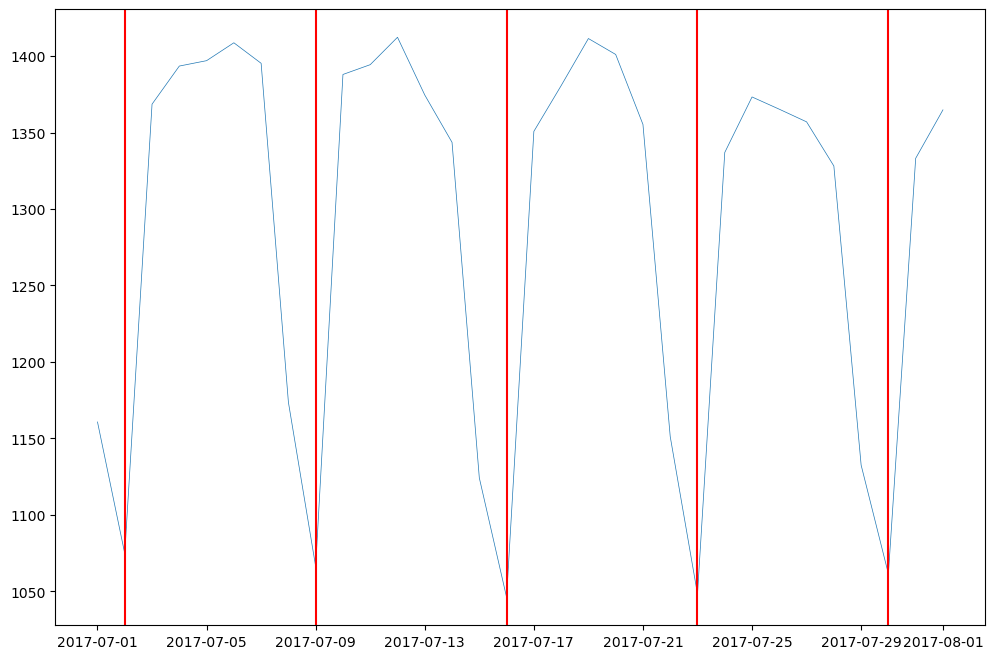

In [21]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'].loc["2017-07-01":"2017-08-01"], label='Consumption', linewidth=0.5)
plt.axvline(pd.to_datetime("2017-07-2"), c="r")
plt.axvline(pd.to_datetime("2017-07-9"), c="r")
plt.axvline(pd.to_datetime("2017-07-16"), c="r")
plt.axvline(pd.to_datetime("2017-07-23"), c="r")
plt.axvline(pd.to_datetime("2017-07-30"), c="r")
plt.show()

In [22]:
df_2 = df.reset_index()
df_2['year'] = [d.year for d in df_2.Date]
#String vs numberical value for month
df_2['month'] = [d.strftime("%b") for d in df_2.Date]
#df_2['month'] = [d.month for d in df_2.Date]
years = df_2['year'].unique()
print(years)
df_2.head()

[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


,Date,Consumption,Wind,Solar,Wind+Solar,year,month
0,2006-01-01,1069.184,NaN,NaN,NaN,2006,Jan
1,2006-01-02,1380.521,NaN,NaN,NaN,2006,Jan
2,2006-01-03,1442.533,NaN,NaN,NaN,2006,Jan
3,2006-01-04,1457.217,NaN,NaN,NaN,2006,Jan
4,2006-01-05,1477.131,NaN,NaN,NaN,2006,Jan


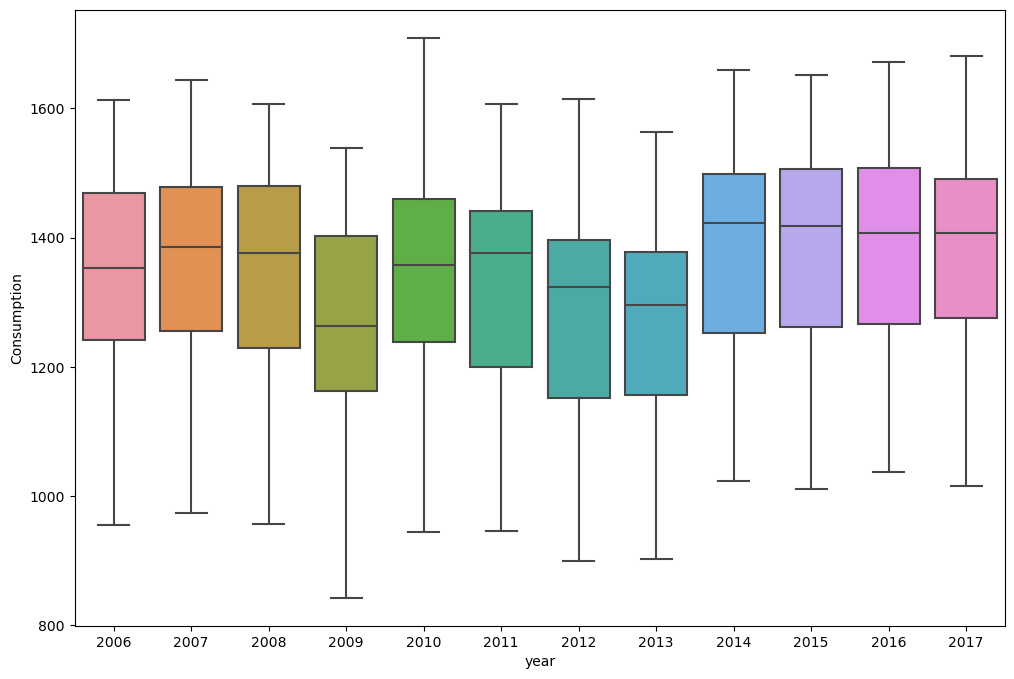

In [23]:
# Boxplot year
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(x='year', y='Consumption', data=df_2)
plt.show()

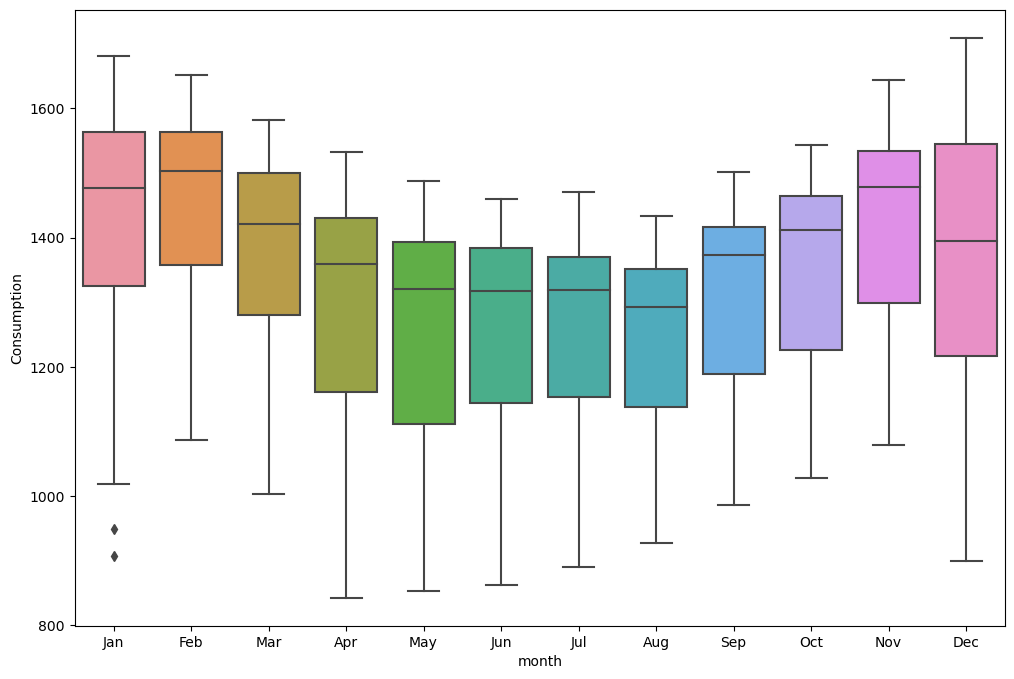

In [24]:
# Boxplot year
import seaborn as sns
plt.figure(figsize=(12,8))
sns.boxplot(x='month', y='Consumption', data=df_2)
plt.show()

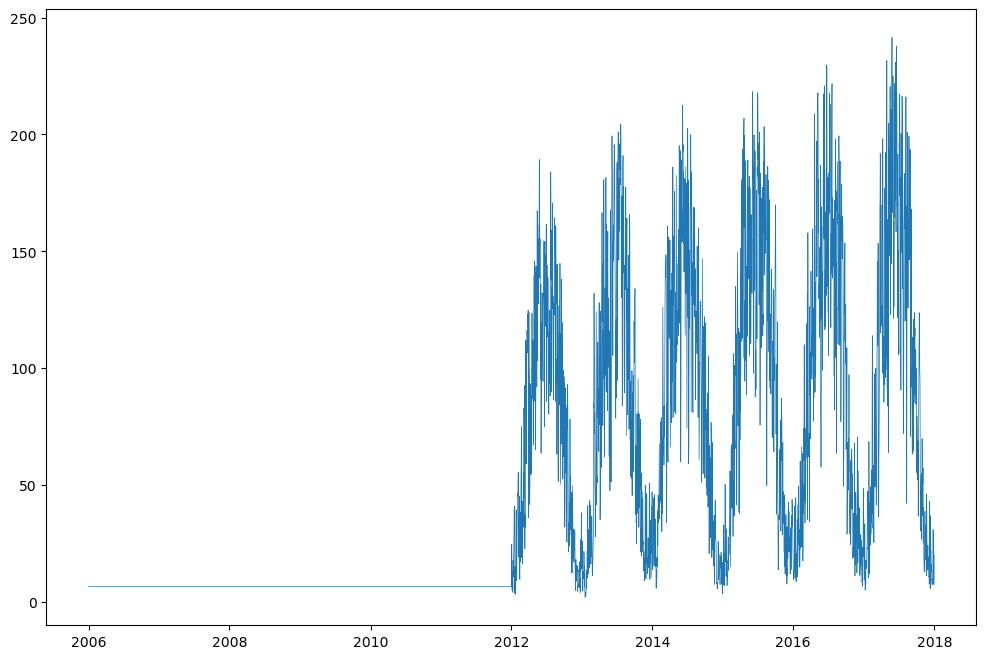

In [25]:
# Plot Solar
plt.figure(figsize=(12,8))
plt.plot(df["Solar"].bfill(axis=0), linewidth=0.5)
plt.show()

In [26]:
df["Consumption"].corr(df["Wind+Solar"])

0.02764784385924092

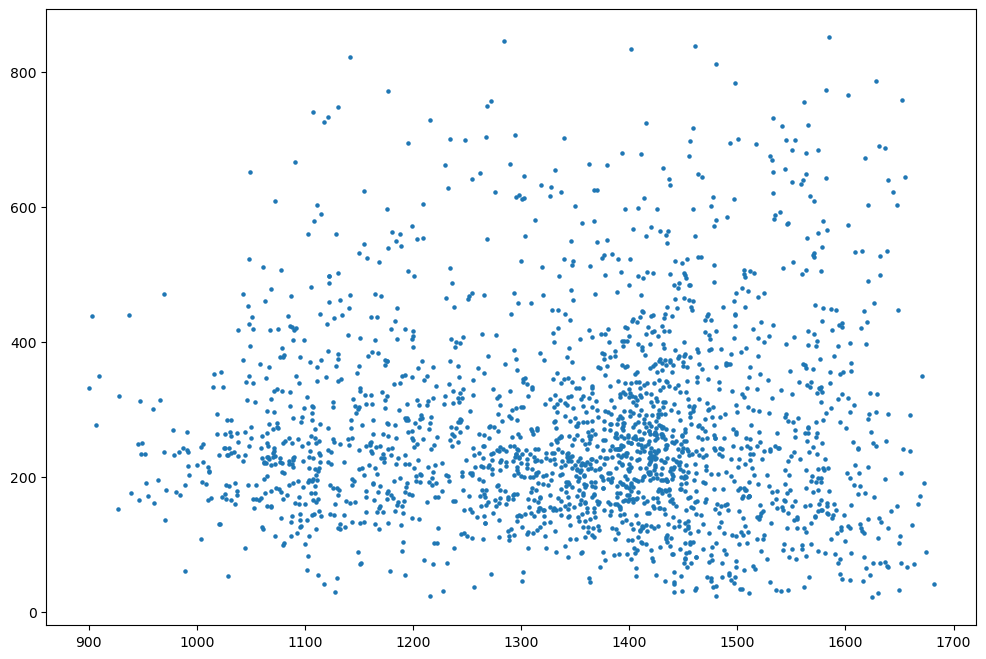

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(df["Consumption"], df["Wind+Solar"], s=5)
plt.show()

In [28]:
df["Solar"].corr(df["Wind"])

-0.3088318295977341

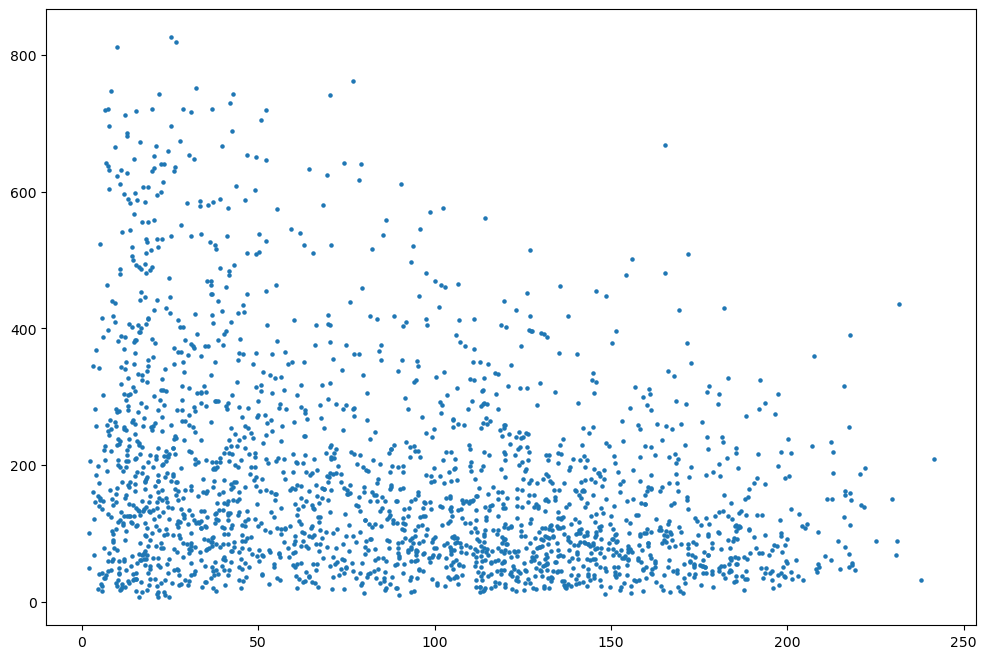

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(df["Solar"], df["Wind"], s=5)
plt.show()

In [30]:
df["Consumption"]["2012-01-01":].corr(df["Wind"]["2012-01-01":])

0.13518640075918514

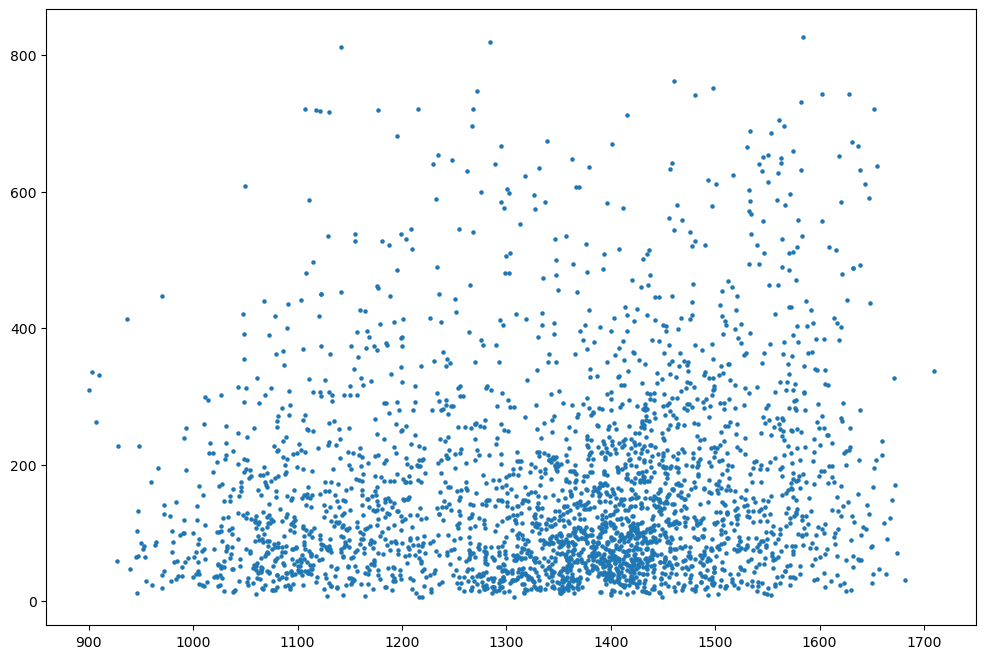

In [31]:
plt.figure(figsize=(12,8))
plt.scatter(df["Consumption"], df["Wind"], s=5)
plt.show()

In [32]:
df["Consumption"]["2012-01-01":].corr(df["Solar"]["2012-01-01":])

-0.27894265519914385

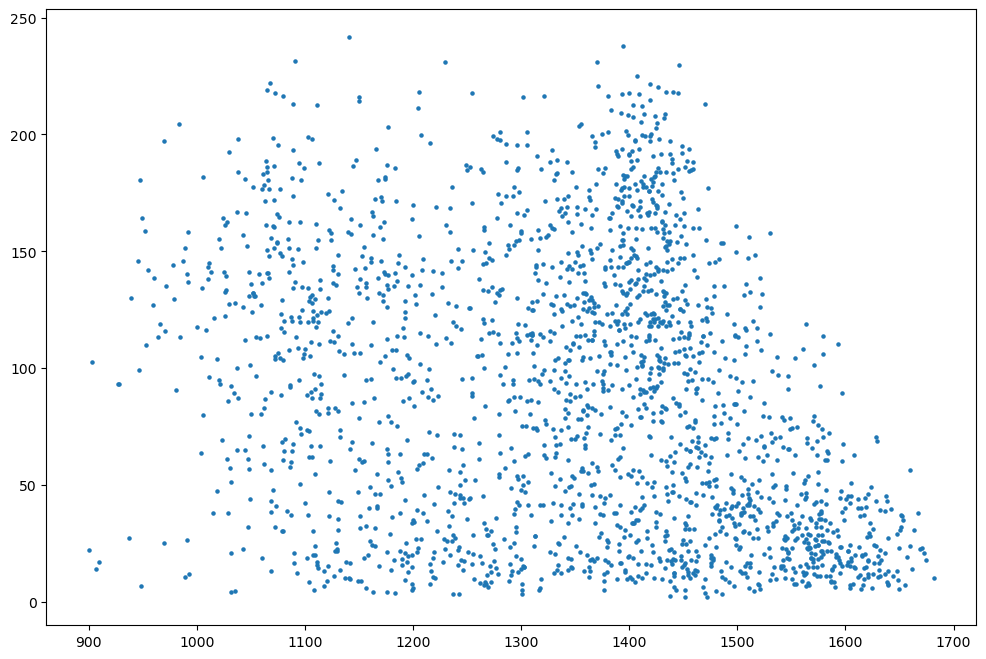

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(df["Consumption"], df["Solar"], s=5)
plt.show()

# Electricity Consumption Prediction

C:\Users\James\anaconda3\envs\3803\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


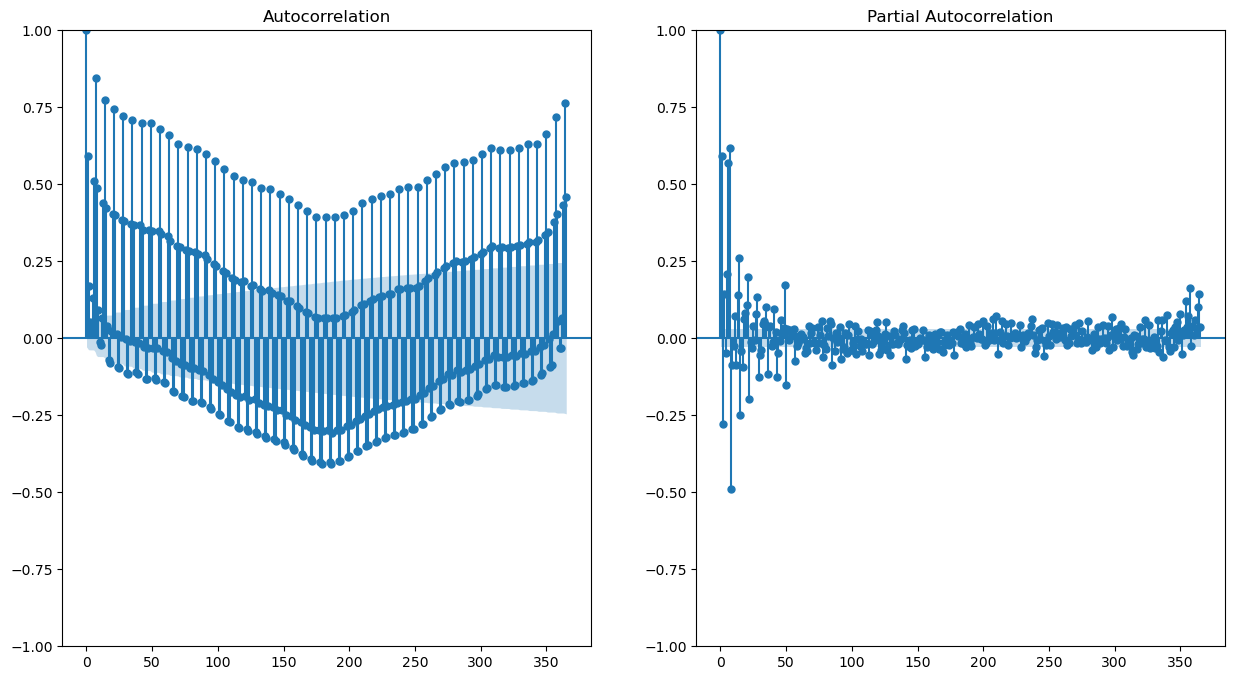

In [34]:
import statsmodels.api as sm

fig, axes = plt.subplots(1, 2, figsize=(15,8))

fig = sm.graphics.tsa.plot_acf(df["Consumption"], lags=365, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df["Consumption"], lags=365, ax=axes[1])
plt.show()

In [97]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Consumption"])
print("ADF Statistic: %.6f" % result[0])
print("p-value: " + str(result[1]))
print("Critical Values:")
for x in result[4]:
    print("\t" + x + ": %.3f" % result[4][x])


ADF Statistic: -6.239148
p-value: 4.744054901842686e-08
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


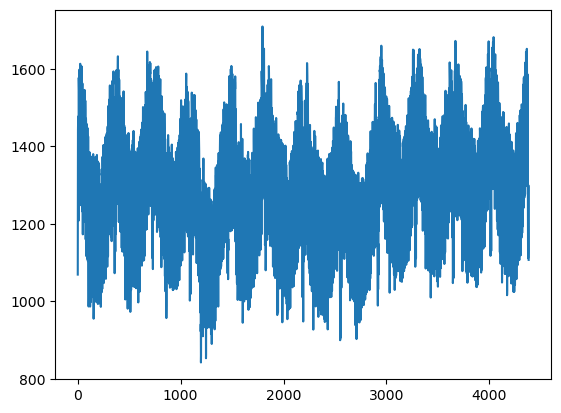

In [36]:
from sklearn.linear_model import LinearRegression

X = np.array(range(len(df['Consumption'])))
y = df['Consumption']

reg = LinearRegression().fit(X.reshape(-1, 1), y)
pred_lin = reg.predict(X.reshape(-1,1))   

plt.plot(df['Consumption'].values)

In [37]:
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
a_2,b_2 = np.polyfit(X+1, np.log(y), 1)
pred_log = a_1 * np.log(X+1) + b_1
pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

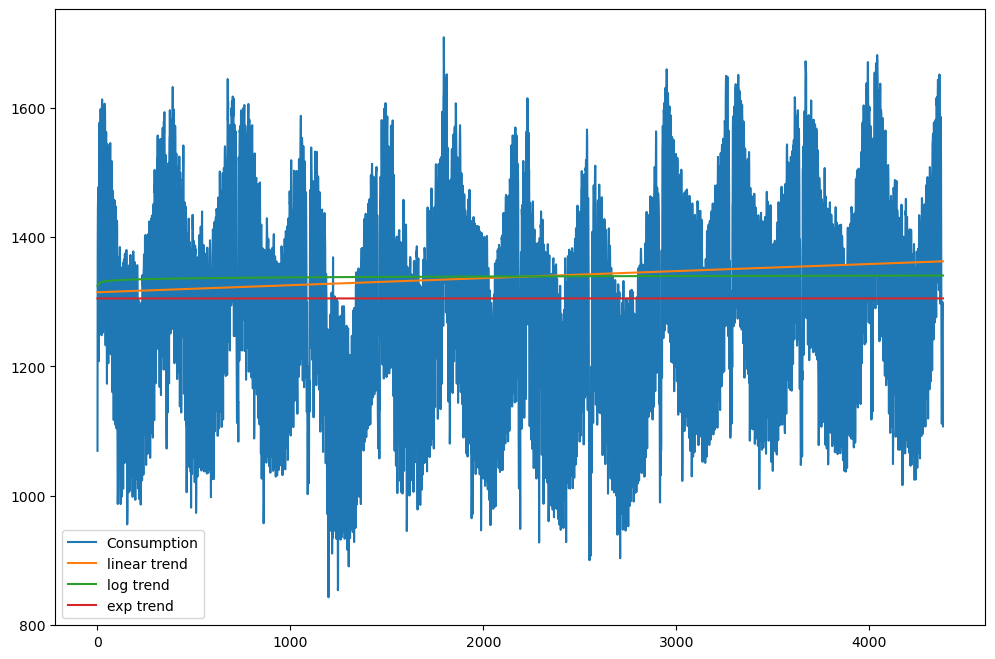

In [38]:
plt.figure(figsize=(12,8))
plt.plot(df["Consumption"].values, label="Consumption")
plt.plot(pred_lin, label="linear trend")
plt.plot(pred_log, label="log trend")
plt.plot(pred_exp, label="exp trend")
plt.legend()

plt.show()

In this case, there seems to be no clear trend pattern. We could consier skipping the de-trending.

We will apply a log transform for what comes next :

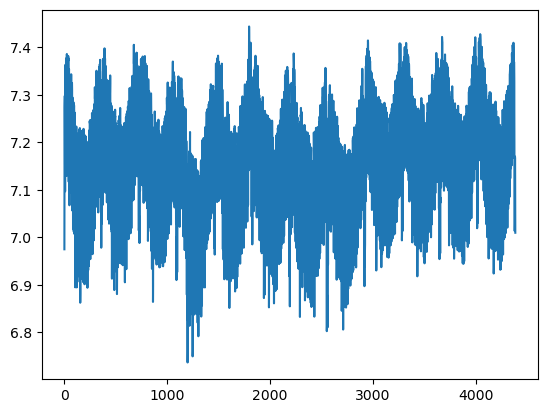

In [39]:
series = np.log(df["Consumption"].values)
plt.plot(series)

In [40]:
from scipy.ndimage import shift

In [41]:
series = shift(series, 365, cval=np.NaN)
series = series[np.isfinite(series)]

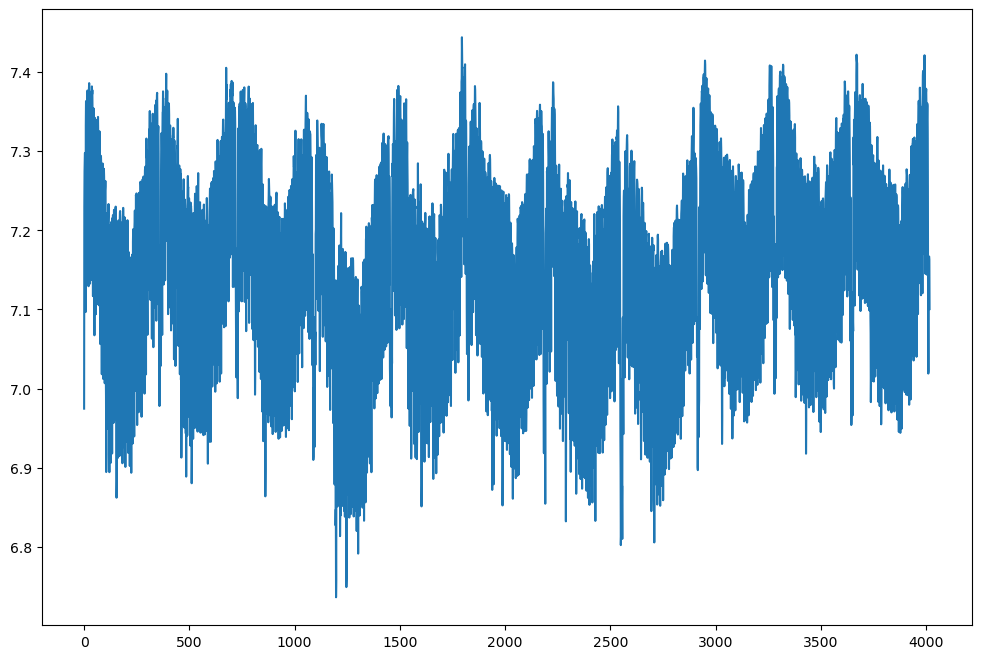

In [42]:
plt.figure(figsize=(12,8))
plt.plot(series, label="linear trend")
plt.show()

In [44]:
result = adfuller(series)
print("ADF Statistic: %.6f" % result[0])
print("p-value: " + str(result[2]))
print("Critical Values:")
for x in result[4]:
    print("\t" + x + ": %.3f" % result[4][x])

ADF Statistic: -6.135816
p-value: 31
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition
decomposition = seasonal_decompose(series, period=365, extrapolate_trend='freq')

<Figure size 1200x800 with 0 Axes>

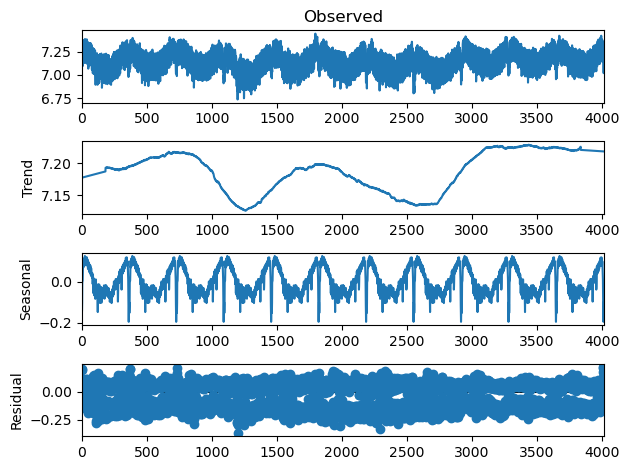

In [48]:
plt.figure(figsize=(12,8))
decomposition.plot()
plt.show()

In [49]:
series = series[-800:]

In [58]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# train, test & history
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

# Moving Average

In [61]:
# walk forward over time steps in test
for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

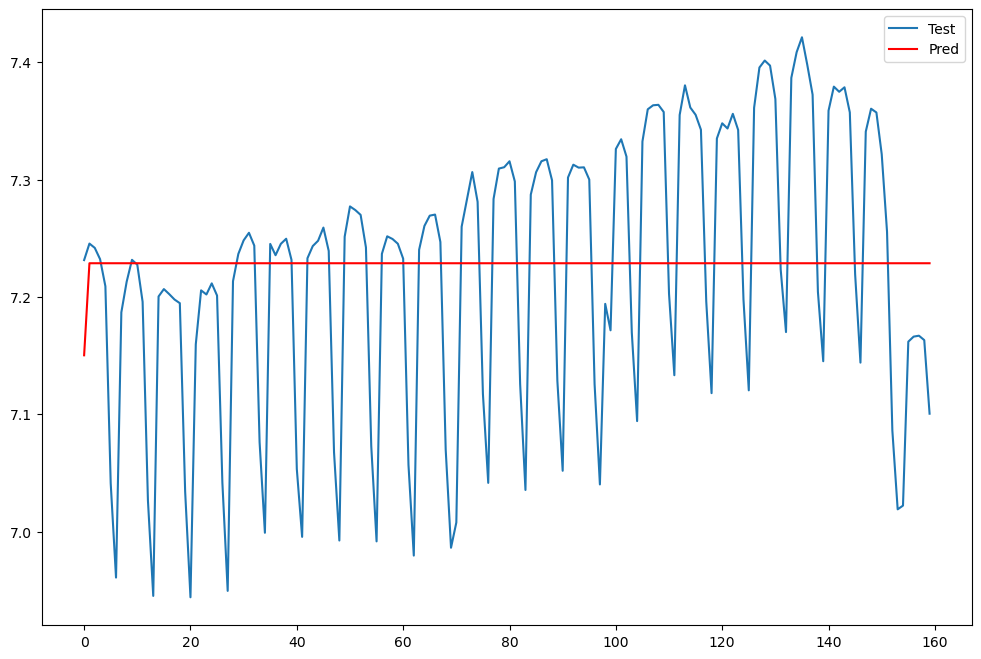

In [64]:
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], c='r', label="Pred")
plt.legend()
plt.show()

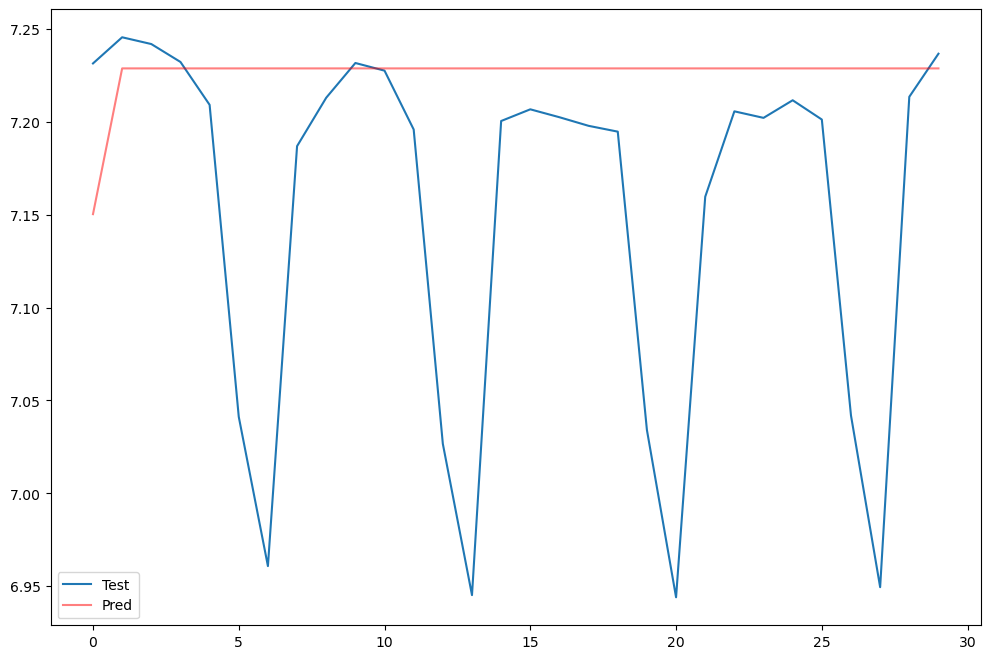

In [65]:
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [67]:
mean_squared_error(test, predictions)

0.013979698738637119

# Auto Regressive

In [72]:
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

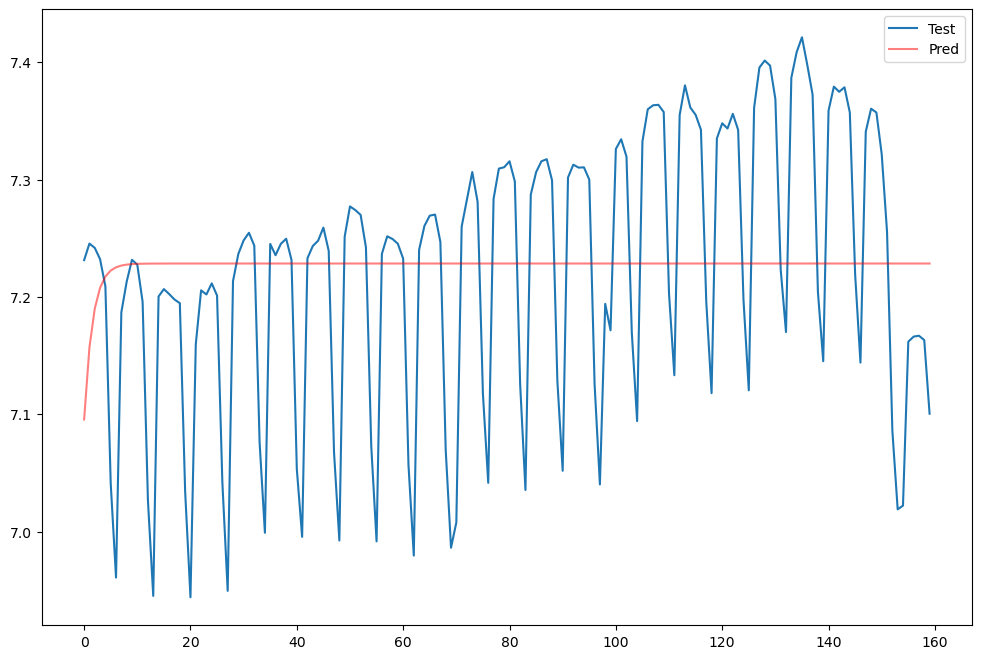

In [73]:
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

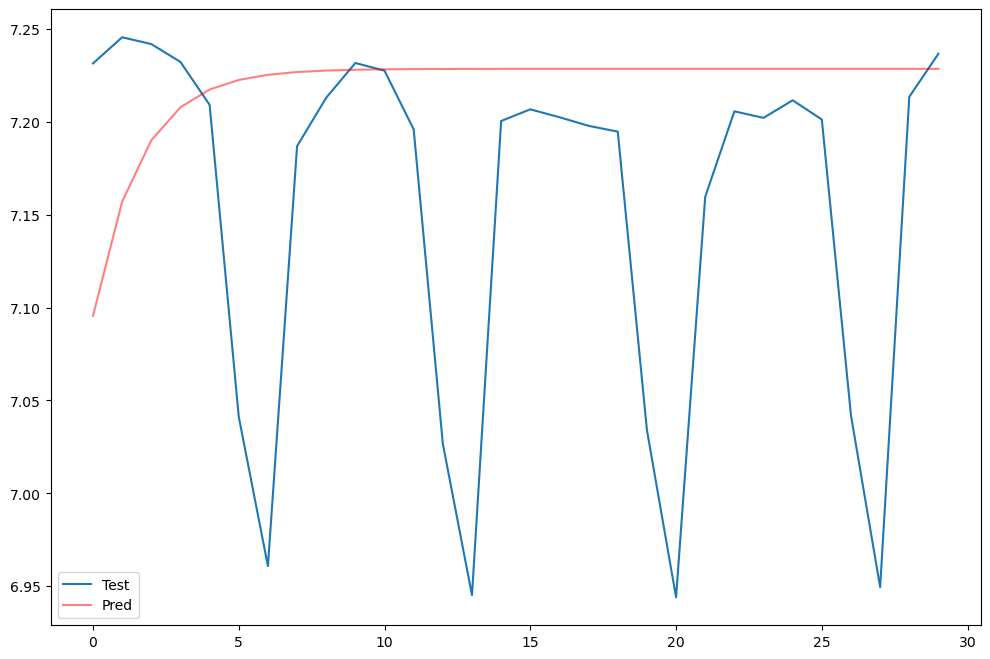

In [74]:
plt.figure(figsize=(12,8))
plt.plot(test[:30], label="Test")
plt.plot(np.array(predictions[:30]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [75]:
mean_squared_error(test, predictions)

0.014089482919877877

# Auto Regressive Moving Average

In [100]:

size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

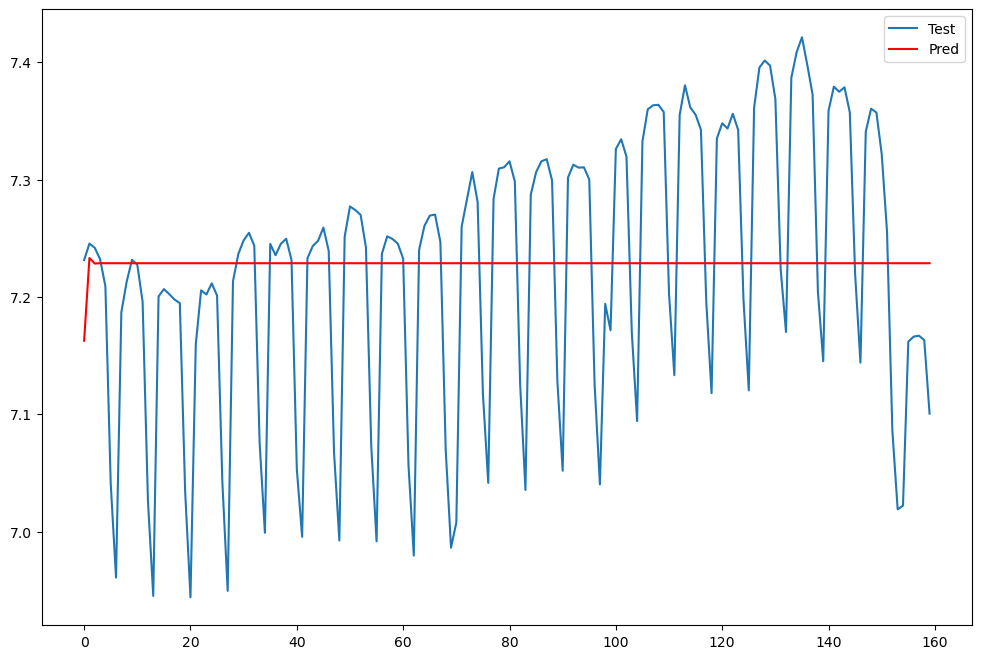

In [102]:
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], c='r', label="Pred")
plt.legend()
plt.show()

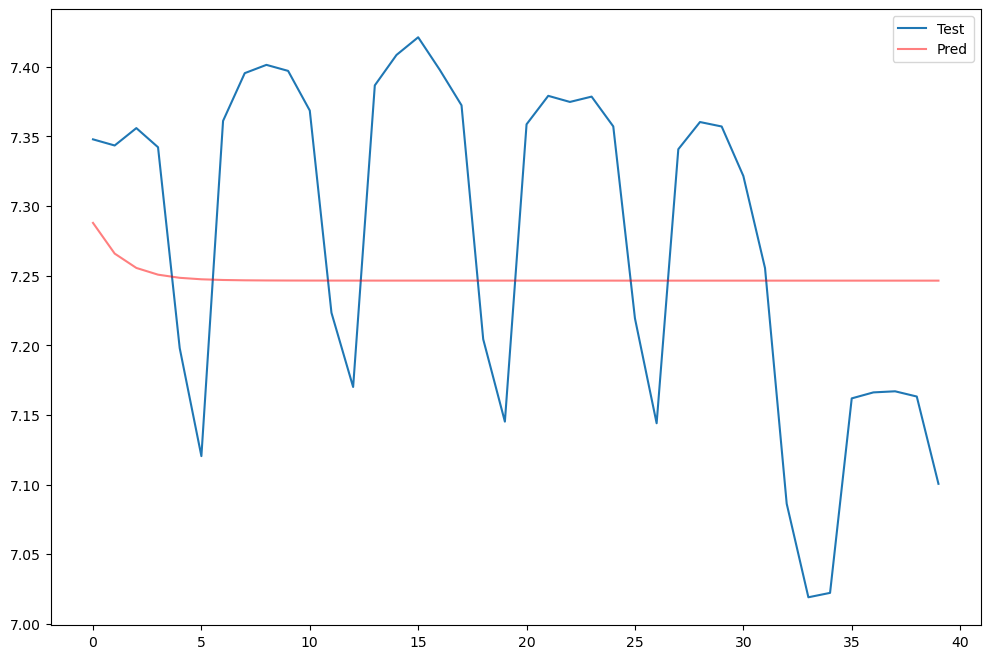

In [121]:
plt.figure(figsize=(12,8))
plt.plot(test[:100], label="Test")
plt.plot(np.array(predictions[:100]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [86]:
mean_squared_error(test, predictions)

0.019261172323438554

# Auto Regressive Integrated Moving Average

In [113]:
size = int(len(series) * 0.95)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

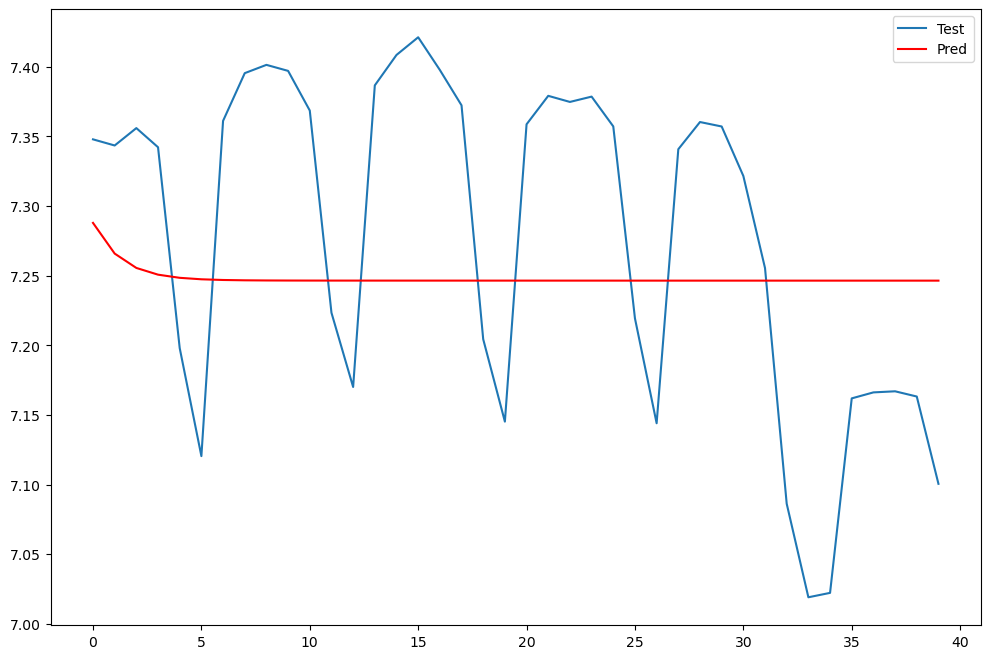

In [114]:
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], c='r', label="Pred")
plt.legend()
plt.show()

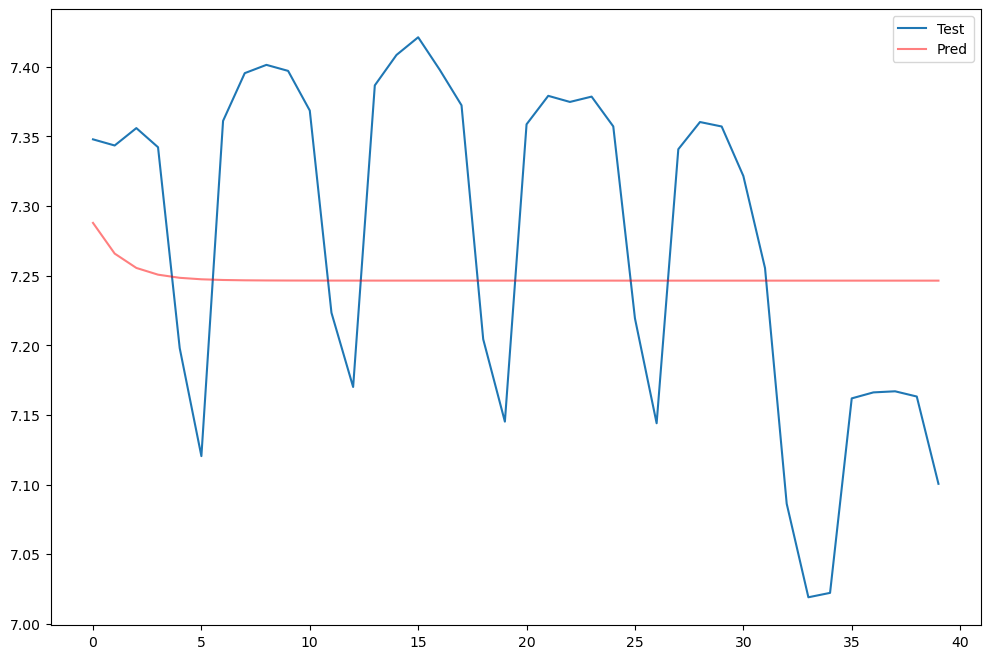

In [120]:
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [116]:
mean_squared_error(test, predictions)

0.014515234904382317

# Seasonal Autoregressive Integrated Moving-Average

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = int(len(series) * 0.80)
train, test = series[0:size], series[size:len(series)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,7))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)

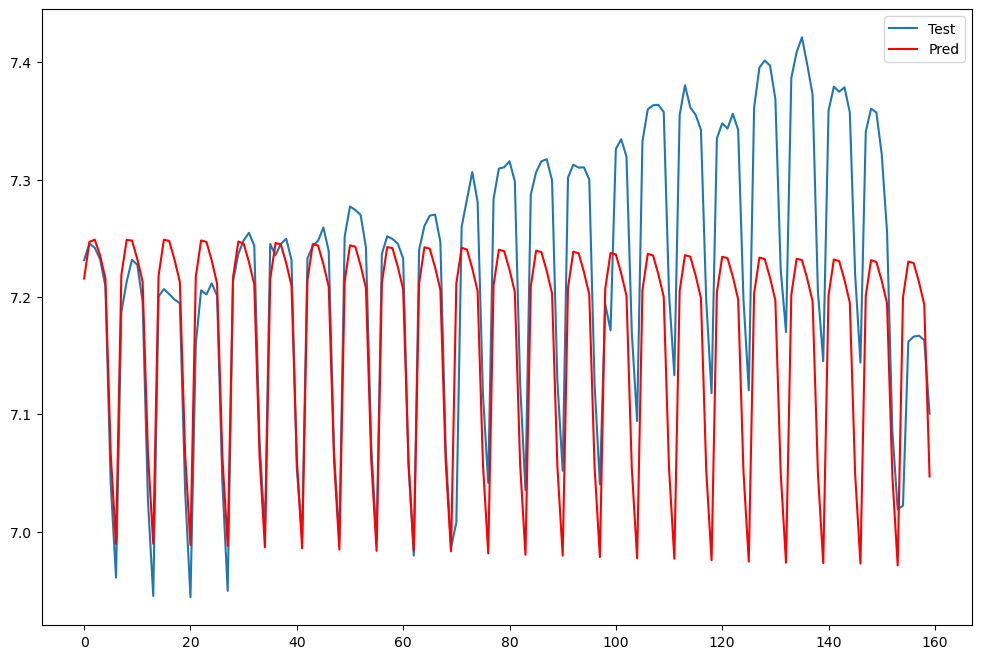

In [123]:
plt.figure(figsize=(12,8))
plt.plot(test, label="Test")
plt.plot(np.array(predictions).reshape(1, -1)[0], c='r', label="Pred")
plt.legend() 
plt.show()

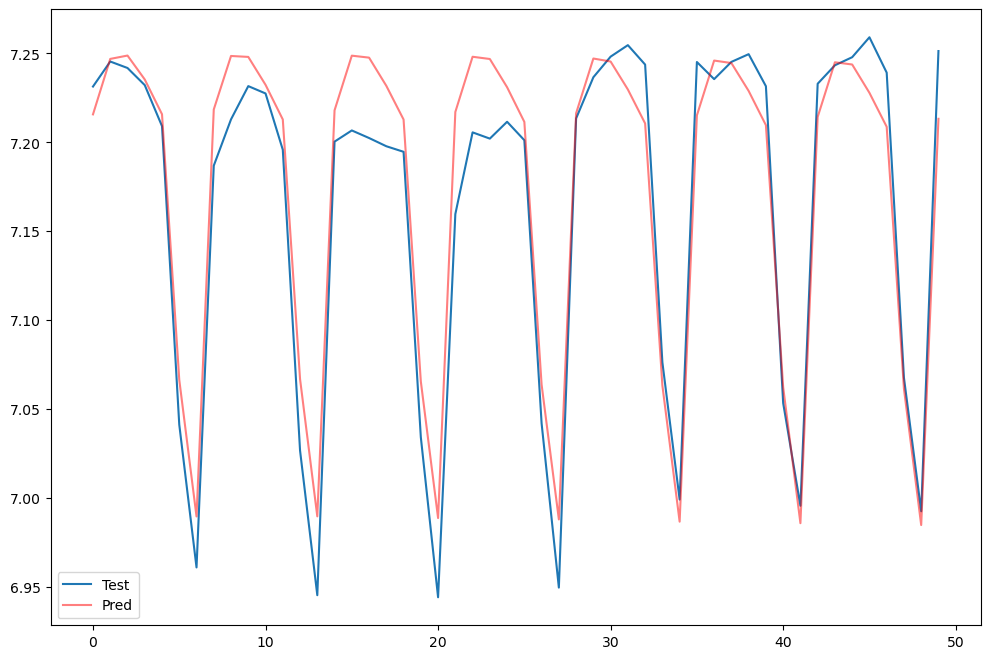

In [124]:
plt.figure(figsize=(12,8))
plt.plot(test[:50], label="Test")
plt.plot(np.array(predictions[:50]).reshape(1,-1)[0], color='red',alpha=0.5, label="Pred")
plt.legend()
plt.show()

In [125]:
mean_squared_error(test, predictions)

0.009003411624559114